In [62]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=UserWarning)

In [63]:
cwd = os.getcwd()

ROOT = os.path.join(cwd, '../../')
DATA_FOLDER = os.path.join(ROOT, 'data/')

In [64]:
colab = False
if colab:
    df = pd.read_pickle('saeb_pb_2017-2007_fe_balanced.pkl')
else:
    df = pd.read_pickle(os.path.join(DATA_FOLDER, 'saeb_pb_2017-2007_fe_balanced.pkl'))
df = df.dropna()
print(len(df))
df.head()

1173


,id_aluno,faz_licao_casa_2.0,reprovacao_0.0,reprovacao_1.0,pai_sabe_ler_escrever_1.0,leitura_revista_comportamento_0.0,leitura_jornais_0.0,escolaridade_pai_4.0,mae_sabe_ler_escrever_1.0,leitura_internet_2.0,tempo_lazer_1.0,escolaridade_mae_4.0,gosta_estudar_disciplina_0.0,gosta_estudar_disciplina_1.0,desempenho_aluno_cat
38709,17486608,True,False,True,False,False,False,False,False,False,False,False,True,False,0
102980,11168544,True,False,True,False,False,False,False,True,False,True,False,False,True,0
55216,3272843,False,True,False,False,False,False,False,True,True,False,True,False,True,0
57311,12149602,False,False,True,False,False,False,False,True,True,False,True,True,False,0
38264,12094178,False,False,False,False,False,False,False,False,False,True,False,True,False,0


In [65]:
exclude = ['ano', 'sigla_uf', 'id_aluno', 'situacao_censo', 'disciplina', 'proficiencia', 'erro_padrao', 'proficiencia_saeb',
       'erro_padrao_saeb', 'sexo', 'raca_cor','ano_nascimento', 'rede', 'id_escola', 'serie', 'turno', 'escola_publica', 'desempenho_aluno']

exclude = [col for col in df.columns if col in exclude]

In [66]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

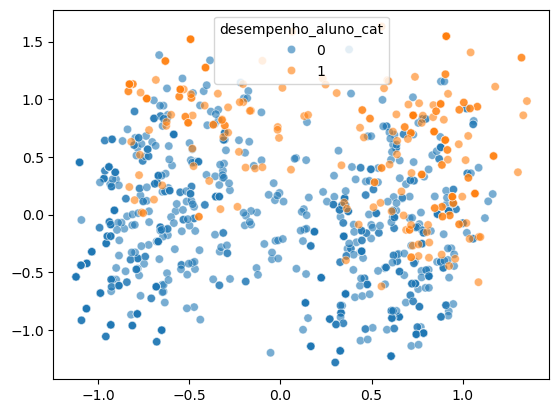

In [67]:
# plotting pca

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.6)
plt.show()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([736, 202]))

In [70]:
# training the model on training set


param_grid = {
    'C': [0.1, 1, 5, 10, 50, 100, 200, 500],
    'gamma': [1e-5, 1e-4, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5, verbose=1)

%time grid.fit(X_train, y_train)
print(grid.best_params_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 20.1 s, sys: 2.01 ms, total: 20.1 s
Wall time: 20.1 s
{'C': 500, 'gamma': 0.05, 'kernel': 'poly'}


In [71]:
clf = SVC(kernel='poly', gamma=0.05, C=500)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       193
           1       0.69      0.64      0.67        42

    accuracy                           0.89       235
   macro avg       0.81      0.79      0.80       235
weighted avg       0.88      0.89      0.88       235



In [72]:
print(X_train.shape)

# computando Ein, Eout e o valor de Eout esperado
y_pred_train = clf.predict(X_train)

Ein = 1 - accuracy_score(y_train, y_pred_train)
Eout = 1 - accuracy_score(y_test, y_pred)

print(f'Ein: {Ein:.2f}')
print(f'Eout: {Eout:.2f}')

print()
# calculando Eout esperado
n_support_vectors = len(clf.support_)
n_samples = len(X_train)

print(f'Número de vetores de suporte: {n_support_vectors}')

Eout_expected = Ein + (n_support_vectors / n_samples)

print(f'Eout esperado: {Eout_expected:.2f}')

(938, 13)
Ein: 0.05
Eout: 0.11

Número de vetores de suporte: 257
Eout esperado: 0.33


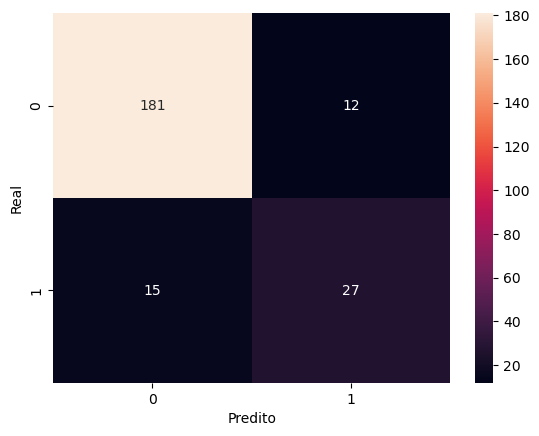

In [73]:
# matriz de confusão do seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [74]:
# acurácia
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')

Acurácia: 0.8851063829787233


# Visualizando com PCA

In [75]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [76]:
# training the model on training set


param_grid = {
    'C': [0.1, 1, 5, 10, 50, 100, 200, 500],
    'gamma': [1e-5, 1e-4, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, verbose=1)

%time grid.fit(X_train_pca, y_train)
print(grid.best_params_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 9.87 s, sys: 3 ms, total: 9.87 s
Wall time: 9.87 s
{'C': 200, 'gamma': 0.1, 'kernel': 'rbf'}


In [77]:
# Train the SVC on the PCA-reduced data
clf_pca = SVC(kernel='rbf', gamma=0.1, C=200)
clf_pca.fit(X_train_pca, y_train)

SVC(C=200, gamma=0.1)

In [78]:

# Predict on the test set
y_pred = clf_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       193
           1       0.56      0.43      0.49        42

    accuracy                           0.84       235
   macro avg       0.72      0.68      0.70       235
weighted avg       0.82      0.84      0.83       235



In [80]:
# computando Ein, Eout e o valor de Eout esperado
y_pred_train = clf_pca.predict(X_train_pca)

Ein = 1 - accuracy_score(y_train, y_pred_train)
Eout = 1 - accuracy_score(y_test, y_pred)

print(f'Ein: {Ein:.2f}')
print(f'Eout: {Eout:.2f}')

print()
# calculando Eout esperado
n_support_vectors = len(clf_pca.support_)
n_samples = len(X_train_pca)

print(f'Número de vetores de suporte: {n_support_vectors}')

Eout_expected = Ein + (n_support_vectors / n_samples)

print(f'Eout esperado: {Eout_expected:.2f}')

Ein: 0.13
Eout: 0.16

Número de vetores de suporte: 302
Eout esperado: 0.45


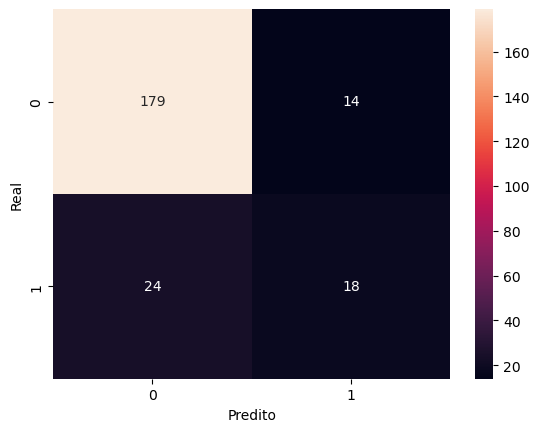

In [81]:
# matriz de confusão do seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

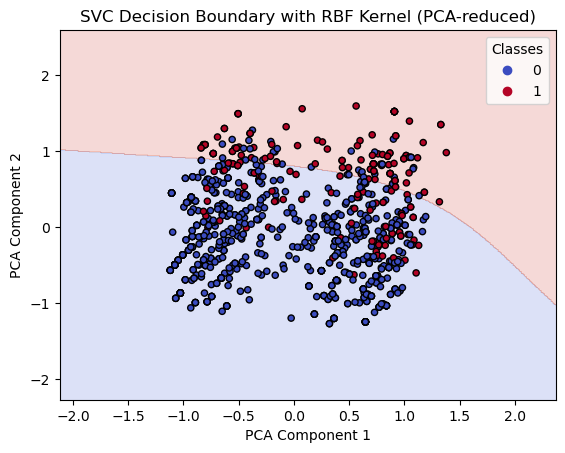

In [79]:
# Step 4: Create a meshgrid in the PCA-transformed feature space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Step 5: Predict over the meshgrid for decision boundary plotting
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 6: Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

# Plot the training points in PCA-reduced space
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k', s=20)

# Formatting
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVC Decision Boundary with RBF Kernel (PCA-reduced)")

# Display the plot with a legend for classes
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()